In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
## Reading the csv file into a variable
phish = pd.read_csv('./CSV/phishing.csv')

In [3]:
## Showing the first 5 rows
phish.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


In [4]:
##Changing the header name to a more suitable header
phish = phish.rename(columns={"Redirecting//": "Redirecting", "PrefixSuffix-": "PrefixSuffix"})
print(len(phish))

11054


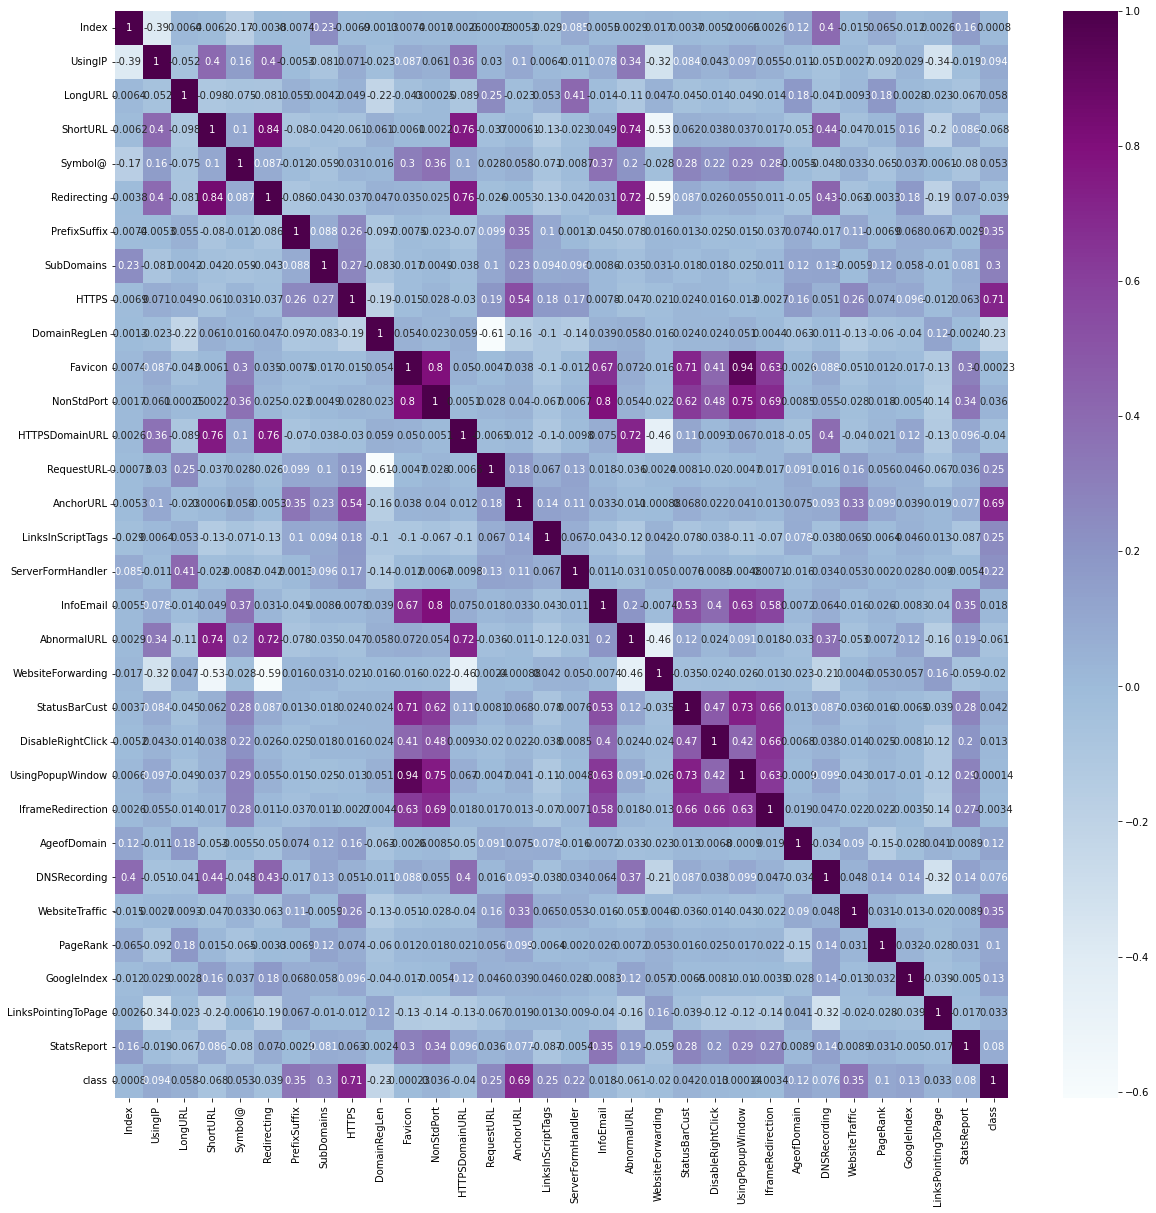

In [5]:
#Correlation heatmap

plt.figure(figsize=(20,20))
sns.heatmap(phish.corr(), annot=True, cmap="BuPu")
plt.show()

In [6]:
#Drop all the suspicious label, only wish to keep phishing/legitimate

indexNames = phish[phish['class'] == 0 ].index
phish.drop(indexNames , inplace=True)
phish = phish.drop(["Index","Symbol@","DomainRegLen","NonStdPort" ,"Favicon","HTTPSDomainURL","LinksInScriptTags","InfoEmail","AbnormalURL","WebsiteForwarding","DisableRightClick","DNSRecording","PageRank","GoogleIndex","LinksPointingToPage","StatsReport","UsingIP", "IframeRedirection"], axis = 1)

In [7]:
print(len(phish))

phish.head()

11054


,LongURL,ShortURL,Redirecting,PrefixSuffix,SubDomains,HTTPS,RequestURL,AnchorURL,ServerFormHandler,StatusBarCust,UsingPopupWindow,AgeofDomain,WebsiteTraffic,class
0,1,1,1,-1,0,1,1,0,-1,1,1,-1,0,-1
1,0,1,1,-1,-1,-1,1,0,-1,1,1,1,1,-1
2,0,1,1,-1,-1,-1,-1,0,-1,1,1,-1,1,-1
3,0,-1,1,-1,1,1,1,0,-1,-1,-1,-1,0,1
4,0,-1,-1,-1,1,1,1,0,-1,1,1,1,1,1


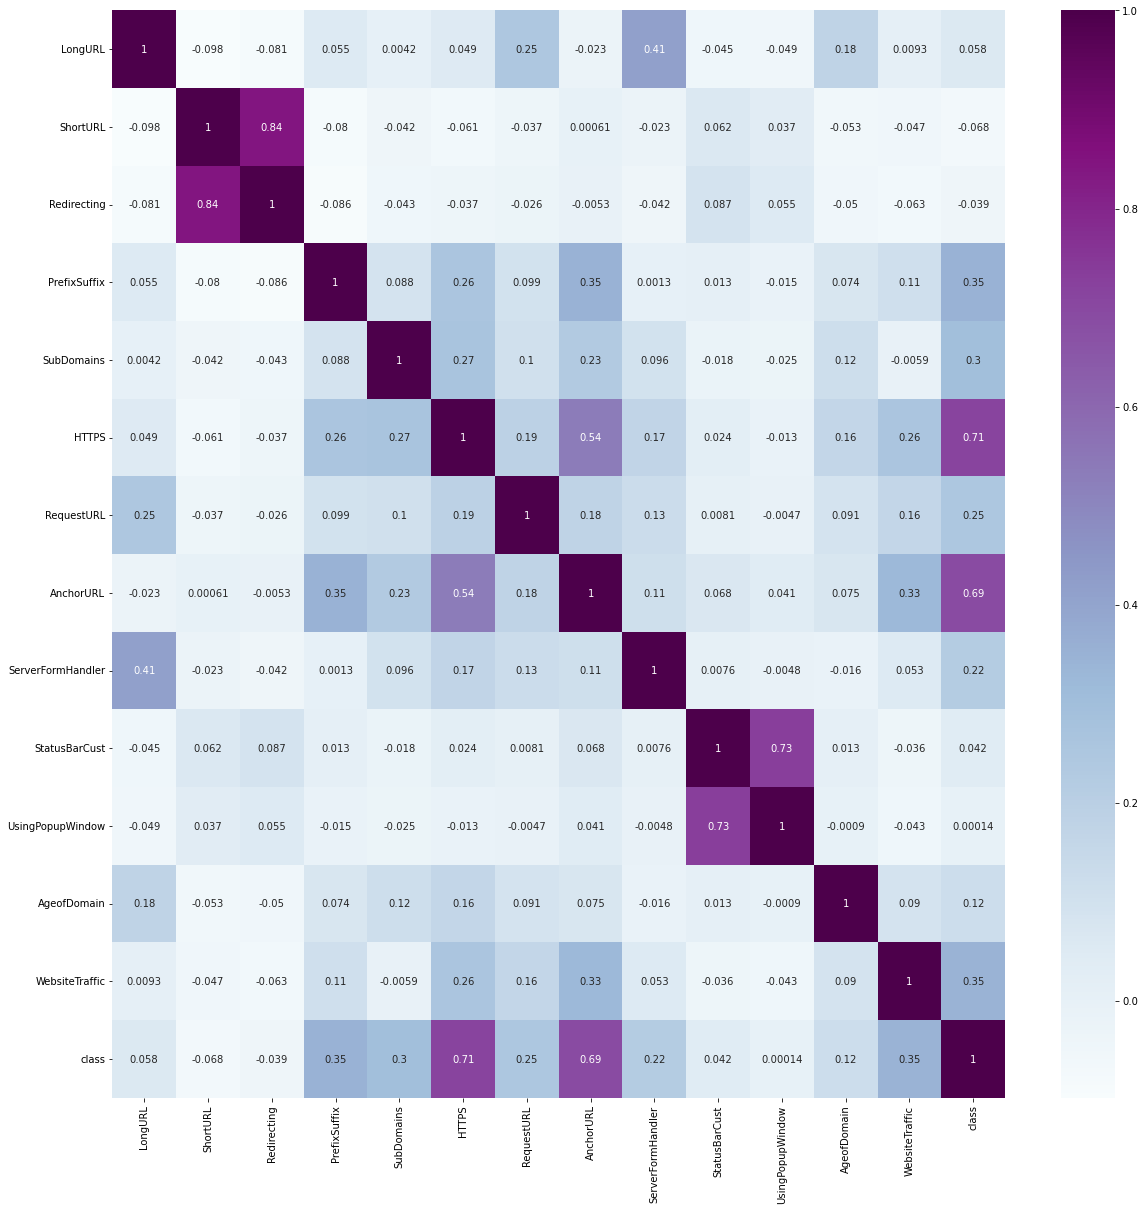

In [8]:
#Correlation heatmap

plt.figure(figsize=(20,20))
sns.heatmap(phish.corr(), annot=True, cmap="BuPu")
plt.show()

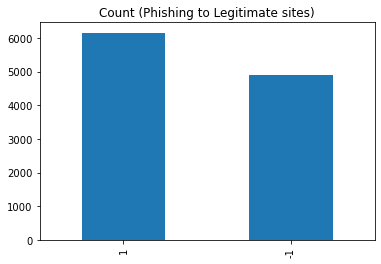

In [9]:

## 1 is phishing, -1 is legitimate
columns = phish.columns.values.tolist()
columns.remove('class')

phish['class'].value_counts().plot(kind='bar', title='Count (Phishing to Legitimate sites)');

In [10]:
## 1 is phishing, -1 is legitimate
phish['class'].unique()

##Since all have a IP Address there isnt a need for it
#phish = phish.drop(['having_IP_Address'], axis = 1)

array([-1,  1], dtype=int64)

In [11]:
##Loading of model
from sklearn.model_selection import train_test_split, cross_val_score

## Parse the column class into y and dropping the class from the dataframe to be stored as variable X
y = phish['class']
X = phish.drop(['class'], axis = 1)

## splitting the dataset into 70% used for training and 30% used for testing
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.30, random_state = 2)

# Gradient Boosting Algorithm

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
GBC.fit(x_train, y_train)
print("Accuracy score (training): {0:.3f}".format(GBC.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(GBC.score(x_test, y_test)))

Accuracy score (training): 0.941
Accuracy score (validation): 0.932


In [13]:
from sklearn.metrics import roc_auc_score, classification_report
prediction = GBC.predict(x_test)

prediction = prediction.astype(int)
y_test = y_test.astype(int)


## Using ROC AUC score to test models accuracy
print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.9307345867174927
              precision    recall  f1-score   support

          -1       0.92      0.92      0.92      1458
           1       0.94      0.94      0.94      1859

    accuracy                           0.93      3317
   macro avg       0.93      0.93      0.93      3317
weighted avg       0.93      0.93      0.93      3317



In [14]:
## Showing the importance of each features in the model
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(GBC.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
HTTPS,0.731
AnchorURL,0.164
WebsiteTraffic,0.042
PrefixSuffix,0.032
SubDomains,0.011
ServerFormHandler,0.008
RequestURL,0.006
Redirecting,0.002
LongURL,0.001


In [15]:
## Printing out the accuracy score of the model against both the training and testing dataset
GBC = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 60, max_depth=8, min_samples_split=2, min_samples_leaf=2, subsample=1, max_features='sqrt', random_state=10)
GBC.fit(x_train, y_train)
print("Accuracy score (training): {0:.3f}".format(GBC.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(GBC.score(x_test, y_test)))

Accuracy score (training): 0.940
Accuracy score (validation): 0.933


In [16]:
from sklearn.metrics import roc_curve, auc

y_pred = GBC.predict(x_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9292414612927433

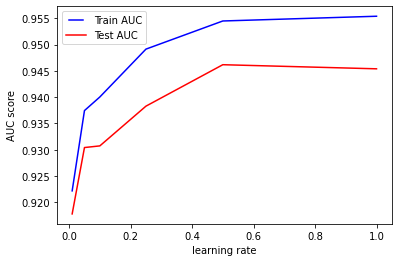

In [17]:
##Determining the optimal learning rate to be used, higher learning rate results in overfitting
##learning rate shrinks the contribution of each tree
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

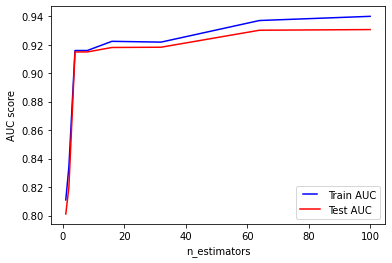

In [18]:
##n_estimators represents the number of trees in the forest
##Increasing it by too much results in overfitting of model too
#Seems 60 n estimator might be optimal
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b' , label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

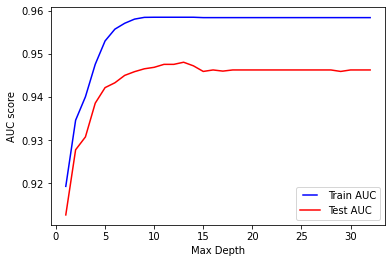

In [19]:
##max_depth. This indicates how deep the built tree can be. 
##The deeper the tree, the more splits it has and it captures more information about how the data. 
##We fit a decision tree with depths ranging from 1 to 32 and plot the training and test errors.

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max Depth')
plt.show()

In [20]:

prediction = GBC.predict(x_test)

prediction = prediction.astype(int)
y_test = y_test.astype(int)

print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.9292414612927433
              precision    recall  f1-score   support

          -1       0.95      0.90      0.92      1458
           1       0.92      0.96      0.94      1859

    accuracy                           0.93      3317
   macro avg       0.94      0.93      0.93      3317
weighted avg       0.93      0.93      0.93      3317



In [21]:
## Showing the importance of each feature within the model
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(GBC.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
HTTPS,0.383
AnchorURL,0.333
WebsiteTraffic,0.103
PrefixSuffix,0.062
SubDomains,0.054
ServerFormHandler,0.022
RequestURL,0.018
AgeofDomain,0.006
LongURL,0.005


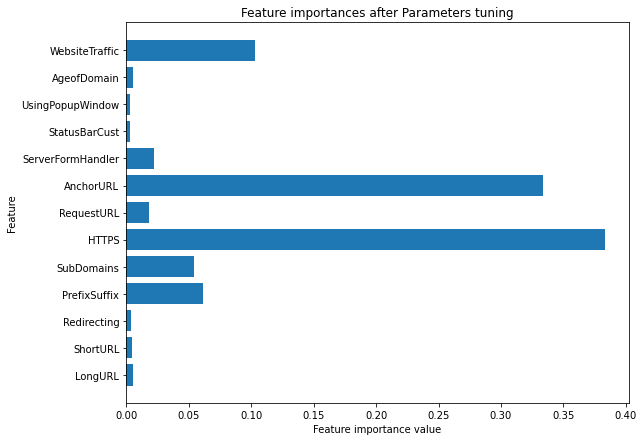

In [22]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = x_train.shape[1]
plt.barh(range(n_features), GBC.feature_importances_, align='center')
plt.yticks(np.arange(n_features), x_train.columns)
plt.title("Feature importances after Parameters tuning")
plt.xlabel("Feature importance value")
plt.ylabel("Feature")
plt.show()

In [23]:
#saving the trained GBC model
pickle.dump(GBC, open("train_GBC_model.sav", 'wb'))

In [24]:
import xgboost as xgb


xgb_cl = xgb.XGBClassifier(learning_rate = 0.6, n_estimators = 100, max_depth=8, random_state=10)
xgb_cl.fit(x_train, y_train)

# Predict
preds = xgb_cl.predict(x_test)

xgb_cl.score(x_test, y_test)

C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9478444377449503

C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


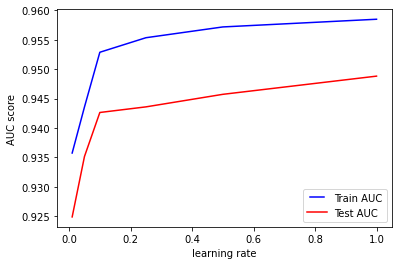

In [25]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = xgb.XGBClassifier(learning_rate=eta)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


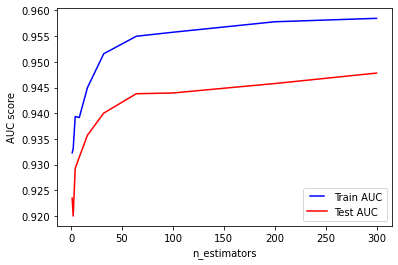

In [26]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300]
train_results = []
test_results = []
for estimator in n_estimators:
   model = xgb.XGBClassifier(n_estimators=estimator)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b' , label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [27]:
prediction = xgb_cl.predict(x_test)

prediction = prediction.astype(int)
y_test = y_test.astype(int)

print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.9476256833806691
              precision    recall  f1-score   support

          -1       0.94      0.95      0.94      1458
           1       0.96      0.95      0.95      1859

    accuracy                           0.95      3317
   macro avg       0.95      0.95      0.95      3317
weighted avg       0.95      0.95      0.95      3317



In [28]:
#saving the trained XGB model
pickle.dump(xgb_cl, open("train_xgb_model.sav", 'wb'))

In [29]:
print("Accuracy score (training): {0:.3f}".format(xgb_cl.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(xgb_cl.score(x_test, y_test)))

Accuracy score (training): 0.959
Accuracy score (validation): 0.948


In [30]:
## Showing the importance of each feature within the model
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(xgb_cl.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
HTTPS,0.379
PrefixSuffix,0.372
AnchorURL,0.135
WebsiteTraffic,0.020
Redirecting,0.019
ShortURL,0.012
SubDomains,0.011
RequestURL,0.011
ServerFormHandler,0.011


In [31]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 20, max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=10)


rfc.fit(x_train, y_train)
print("Accuracy score (training): {0:.3f}".format(rfc.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(rfc.score(x_test, y_test)))

Accuracy score (training): 0.951
Accuracy score (validation): 0.943


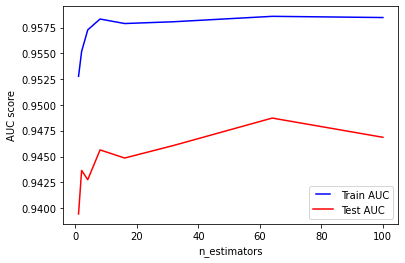

In [32]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []
for estimator in n_estimators:
   model = RandomForestClassifier(n_estimators=estimator)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b' , label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

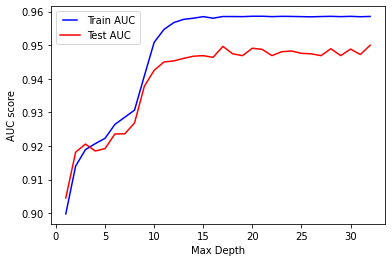

In [33]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   model = RandomForestClassifier(max_depth=max_depth)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max Depth')
plt.show()

In [34]:
prediction = rfc.predict(x_test)

prediction = prediction.astype(int)
y_test = y_test.astype(int)

print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.9418158869725821
              precision    recall  f1-score   support

          -1       0.94      0.93      0.94      1458
           1       0.95      0.95      0.95      1859

    accuracy                           0.94      3317
   macro avg       0.94      0.94      0.94      3317
weighted avg       0.94      0.94      0.94      3317



In [35]:
#saving the trained random forest model
pickle.dump(rfc, open("train_rfc_model.sav", 'wb'))

In [36]:
## Showing the importance of each features within the model
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
HTTPS,0.417
AnchorURL,0.293
WebsiteTraffic,0.109
SubDomains,0.066
PrefixSuffix,0.041
ServerFormHandler,0.021
RequestURL,0.016
LongURL,0.008
AgeofDomain,0.007


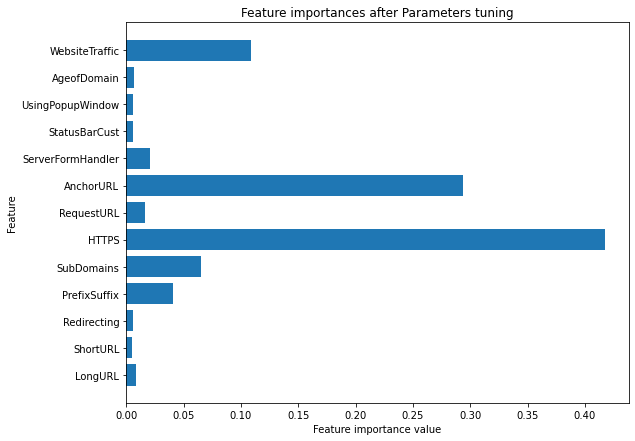

In [37]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = x_train.shape[1]
plt.barh(range(n_features), rfc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), x_train.columns)
plt.title("Feature importances after Parameters tuning")
plt.xlabel("Feature importance value")
plt.ylabel("Feature")
plt.show()